In [1]:
import os
import numpy as np
import nibabel as nib
from glob import glob
from nilearn.masking import apply_mask, unmask
from nilearn.maskers import NiftiMasker
from nilearn import image
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy


def load_conjunction_mask(subject, sessions, threshold=0.5):
    mask_fns = [f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/atlas/sub-{subject}_ses-{session}_task-trailer_part-mag_atlas-cit168_desc-brain_mask.nii.gz' for session in sessions]
    brainmask = 1.0
    for mask_fn in mask_fns:
        bm = nib.load(mask_fn).get_fdata()
        bm_bin = (bm > threshold).astype(float)  # will only return 0 or 1
        brainmask *= bm_bin
    
    affine = nib.load(mask_fns[0]).affine
    return nib.Nifti1Image(brainmask, affine)


def noise_ceiling_estimation(time_series):
    n_sessions = len(time_series)
    n_voxels = time_series[0].shape[1]
    n_pairs = n_sessions * (n_sessions - 1) // 2

    # Compute pairwise correlations for each voxel
    pairwise_correlations = np.zeros((n_voxels, n_pairs))
    for voxel in range(n_voxels):
        pair_idx = 0
        for session1, session2 in itertools.combinations(range(n_sessions), 2):
            correlation, _ = pearsonr(time_series[session1][:, voxel], time_series[session2][:, voxel])
            pairwise_correlations[voxel, pair_idx] = correlation
            pair_idx += 1

    # Calculate the noise ceiling for each voxel
    noise_ceiling = np.mean(pairwise_correlations, axis=1)

    return noise_ceiling

def explainable_variance(data, bias_correction=False, do_zscore=True):
    """Compute explainable variance for a set of voxels."""
    if do_zscore:
        data = scipy.stats.zscore(data, axis=1)

    mean_var = data.var(axis=1, dtype=np.float64, ddof=1).mean(axis=0)
    var_mean = data.mean(axis=0).var(axis=0, dtype=np.float64, ddof=1)
    ev = var_mean / mean_var

    if bias_correction:
        n_repeats = data.shape[0]
        ev = ev - (1 - ev) / (n_repeats - 1)
    return ev

def calculate_tsnr(time_series_array):
    """Calculate temporal signal-to-noise ratio for a set of voxels."""
    mean_signal = np.mean(time_series_array, axis=1)
    std_signal = np.std(time_series_array, axis=1)
    tsnr = mean_signal / std_signal
    return tsnr

subjects = ['Damy001', 'Damy003']
sessions = ['1', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']

all_noise_ceilings = []
all_explainable_variances = []
all_tsnrs = []

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
    
    



/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
for subject in subjects:
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]

    # Extract time series for each session
    time_series = []
    for session, data in zip(sessions, tqdm(fmri_data, desc=f"Extracting time series for {subject}")):
        mask_nii = load_conjunction_mask(subject, session)
        masker = NiftiMasker(mask_img=mask_nii)
        masker.fit(data)
        time_series.append(masker.transform(data))

    noise_ceiling = noise_ceiling_estimation(time_series)
    all_noise_ceilings.append(noise_ceiling)

    time_series_array = np.stack(time_series, axis=0)
    ev = explainable_variance(time_series_array)
    ev_no_na = ev[np.isfinite(ev)]
    all_explainable_variances.append(ev_no_na)

    tsnr = calculate_tsnr(time_series_array)
    tsnr_no_na = tsnr[np.isfinite(tsnr)]
    all_tsnrs.append(tsnr_no_na)



Extracting time series for Damy001:  92%|█████████▏| 11/12 [09:50<00:53, 53.69s/it]
/home/zdiamand/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
Extracting time series for Damy003:  92%|█████████▏| 11/12 [08:51<00:48, 48.32s/it]


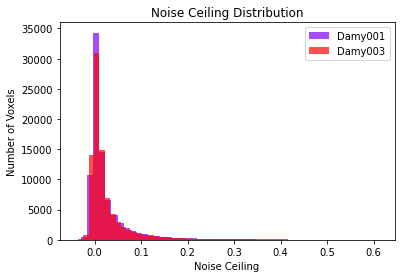

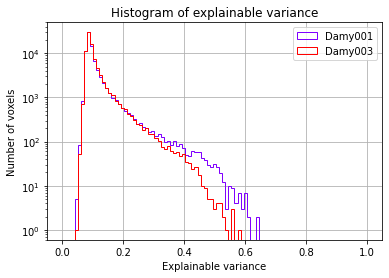

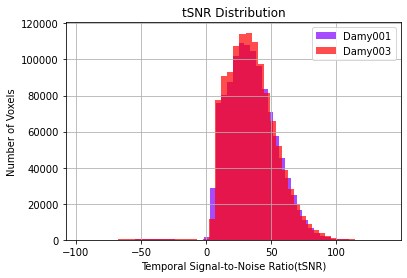

In [3]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, noise_ceiling, color in zip(subjects, all_noise_ceilings, colors):
    plt.hist(noise_ceiling, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Noise Ceiling')
plt.ylabel('Number of Voxels')
plt.title('Noise Ceiling Distribution')
plt.legend()
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, ev_no_na, color in zip(subjects, all_explainable_variances, colors):
    plt.hist(ev_no_na, bins=np.linspace(0, 1, 100), log=True, histtype='step', color=color, label=subject)
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.legend()
plt.grid('on')
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, tsnr_no_na, color in zip(subjects, all_tsnrs, colors):
    plt.hist(tsnr_no_na, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Temporal Signal-to-Noise Ratio(tSNR)')
plt.ylabel('Number of Voxels')
plt.title('tSNR Distribution')
plt.legend()
plt.grid('on')
plt.show()

In [4]:
# Create a function to compute the mean EPI image from a list of fmri_data
def compute_mean_epi_img(fmri_data):
    return image.mean_img(fmri_data)

mean_epi_img = compute_mean_epi_img(fmri_data)

for subject, noise_ceiling, ev, tsnr, color in zip(subjects, all_noise_ceilings, all_explainable_variances, all_tsnrs, colors):
    # Compute the mean EPI image
    

    # Convert the noise ceiling values back to a brain volume
    noise_ceiling_img = masker.inverse_transform(noise_ceiling)

    # Visualize the spatial distribution of noise ceiling values
    noise_ceiling_plot = plotting.plot_stat_map(noise_ceiling_img, bg_img=mean_epi_img, threshold=0, title=f'Noise Ceiling Estimation for {subject}', cmap='viridis')
    plt.show()

    # Convert the explainable variance values back to a brain volume
    ev_img = masker.inverse_transform(ev)

    # Visualize the spatial distribution
    ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title=f'Explainable Variance for {subject}', cmap='viridis')
    plt.show()

    # Calculate the mean tSNR across sessions
    mean_tsnr = np.mean(tsnr, axis=0)

    # Convert the mean tSNR values back to a brain volume
    mean_tsnr_img = masker.inverse_transform(mean_tsnr)

    # Visualize the spatial distribution
    mean_tsnr_plot = plotting.plot_stat_map(mean_tsnr_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Temporal Signal-to-Noise Ratio (tSNR) for {subject}', cmap='viridis')
    plt.show()


/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


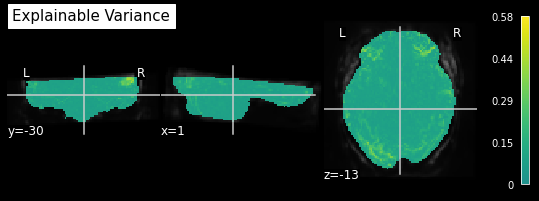

In [6]:
# Convert the explainable variance values back to a brain volume
from nilearn import plotting
ev_img = masker.inverse_transform(ev)

# Visualize the spatial distribution
ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title='Explainable Variance', cmap='viridis')
plt.show()


/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


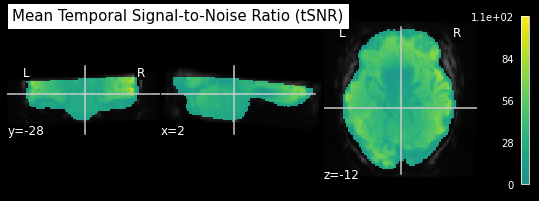

In [7]:
# Calculate the mean tSNR across sessions
mean_tsnr = np.mean(tsnr, axis=0)

# Convert the mean tSNR values back to a brain volume
mean_tsnr_img = masker.inverse_transform(mean_tsnr)

# Visualize the spatial distribution
mean_tsnr_plot = plotting.plot_stat_map(mean_tsnr_img, bg_img=mean_epi_img, threshold=0, title='Mean Temporal Signal-to-Noise Ratio (tSNR)', cmap='viridis')
plt.show()


# Amygdala

In [8]:
def load_amygdala_mask(subject, session, atlas_file):
    atlas_data = nib.load(atlas_file).get_fdata()
    amygdala_labels = [17, 18, 19]

    # Create a binary mask that includes voxels with any of the amygdala label values
    amygdala_mask = np.zeros_like(atlas_data)
    for label in amygdala_labels:
        amygdala_mask[atlas_data == label] = 1

    return nib.Nifti1Image(amygdala_mask, nib.load(atlas_file).affine)


def load_conjunction_amygdala_mask(subject, sessions):
    atlas_files = [f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/atlas/sub-{subject}_ses-{session}_task-trailer_part-mag_atlas-cit168_dseg.nii.gz' for session in sessions]

    conjunction_amygdala_mask = 1.0
    for session, atlas_file in zip(sessions, atlas_files):
        amygdala_mask_nii = load_amygdala_mask(subject, session, atlas_file)
        amygdala_mask = amygdala_mask_nii.get_fdata()
        amygdala_mask_bin = (amygdala_mask > 0.5).astype(float)
        conjunction_amygdala_mask *= amygdala_mask_bin

    affine = nib.load(atlas_files[0]).affine
    return nib.Nifti1Image(conjunction_amygdala_mask, affine)



In [9]:
subjects = ['Damy001', 'Damy003']
sessions = ['1', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']

all_noise_ceilings = []
all_explainable_variances = []
all_tsnrs = []

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))


for subject in subjects:
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]

    # Extract time series for each session
    time_series = []
    for session, data in zip(sessions, tqdm(fmri_data, desc=f"Extracting time series for {subject}")):
        mask_nii = load_conjunction_amygdala_mask(subject, session)
        masker = NiftiMasker(mask_img=mask_nii)
        masker.fit(data)
        time_series.append(masker.transform(data))

    noise_ceiling = noise_ceiling_estimation(time_series)
    all_noise_ceilings.append(noise_ceiling)

    time_series_array = np.stack(time_series, axis=0)
    ev = explainable_variance(time_series_array)
    ev_no_na = ev[np.isfinite(ev)]
    all_explainable_variances.append(ev_no_na)

    tsnr = calculate_tsnr(time_series_array)
    tsnr_no_na = tsnr[np.isfinite(tsnr)]
    all_tsnrs.append(tsnr_no_na)



Extracting time series for Damy003:  92%|█████████▏| 11/12 [09:19<00:50, 50.82s/it]


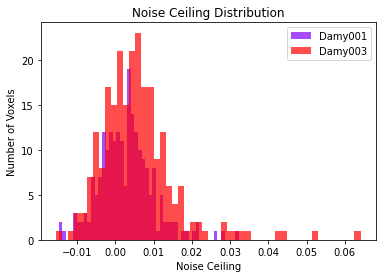

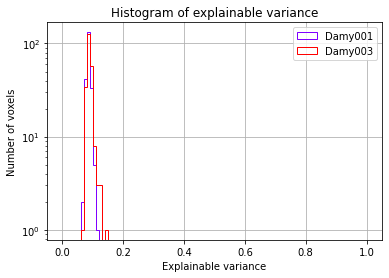

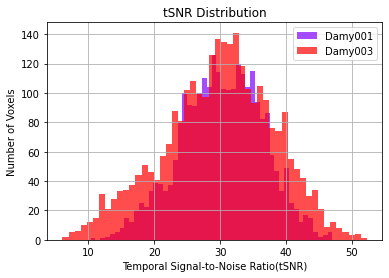

In [10]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, noise_ceiling, color in zip(subjects, all_noise_ceilings, colors):
    plt.hist(noise_ceiling, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Noise Ceiling')
plt.ylabel('Number of Voxels')
plt.title('Noise Ceiling Distribution')
plt.legend()
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, ev_no_na, color in zip(subjects, all_explainable_variances, colors):
    plt.hist(ev_no_na, bins=np.linspace(0, 1, 100), log=True, histtype='step', color=color, label=subject)
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.legend()
plt.grid('on')
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, tsnr_no_na, color in zip(subjects, all_tsnrs, colors):
    plt.hist(tsnr_no_na, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Temporal Signal-to-Noise Ratio(tSNR)')
plt.ylabel('Number of Voxels')
plt.title('tSNR Distribution')
plt.legend()
plt.grid('on')
plt.show()

In [11]:
# Create a function to compute the mean EPI image from a list of fmri_data
def compute_mean_epi_img(fmri_data):
    return image.mean_img(fmri_data)

mean_epi_img = compute_mean_epi_img(fmri_data)

for subject, noise_ceiling, ev, tsnr, color in zip(subjects, all_noise_ceilings, all_explainable_variances, all_tsnrs, colors):
    # Compute the mean EPI image
    

    # Convert the noise ceiling values back to a brain volume
    noise_ceiling_img = masker.inverse_transform(noise_ceiling)

    # Visualize the spatial distribution of noise ceiling values
    noise_ceiling_plot = plotting.plot_stat_map(noise_ceiling_img, bg_img=mean_epi_img, threshold=0, title=f'Noise Ceiling Estimation for {subject}', cmap='viridis')
    plt.show()

    # Convert the explainable variance values back to a brain volume
    ev_img = masker.inverse_transform(ev)

    # Visualize the spatial distribution
    ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title=f'Explainable Variance for {subject}', cmap='viridis')
    plt.show()

    # Calculate the mean tSNR across sessions
    mean_tsnr = np.mean(tsnr, axis=0)

    # Convert the mean tSNR values back to a brain volume
    mean_tsnr_img = masker.inverse_transform(mean_tsnr)

    # Visualize the spatial distribution
    mean_tsnr_plot = plotting.plot_stat_map(mean_tsnr_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Temporal Signal-to-Noise Ratio (tSNR) for {subject}', cmap='viridis')
    plt.show()


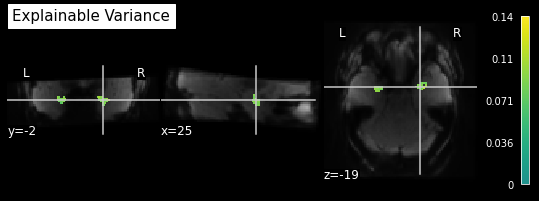

In [12]:
# Convert the explainable variance values back to a brain volume
ev_img = masker.inverse_transform(ev)

# Visualize the spatial distribution
ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title='Explainable Variance', cmap='viridis')
plt.show()


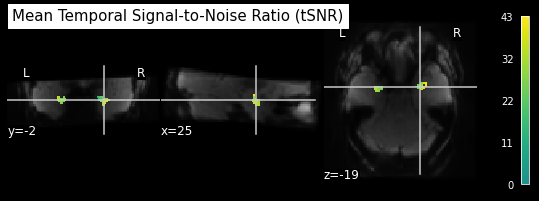

In [13]:
# Calculate the mean tSNR across sessions
mean_tsnr = np.mean(tsnr, axis=0)

# Convert the mean tSNR values back to a brain volume
mean_tsnr_img = masker.inverse_transform(mean_tsnr)

# Visualize the spatial distribution
mean_tsnr_plot = plotting.plot_stat_map(mean_tsnr_img, bg_img=mean_epi_img, threshold=0, title='Mean Temporal Signal-to-Noise Ratio (tSNR)', cmap='viridis')
plt.show()


# Alternative tSNR approach with conjunction mask - ignore for now

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from nilearn.maskers import NiftiMasker
from tqdm import tqdm

def load_conjunction_mask(subject, sessions):
    mask_fns = [f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/atlas/sub-{subject}_ses-{session}_task-trailer_part-mag_atlas-cit168_desc-brain_mask.nii.gz' for session in sessions]
    brainmask = 1.0
    for mask_fn in mask_fns:
        bm = nib.load(mask_fn).get_fdata()
        brainmask *= bm
    return brainmask.astype(bool)

subjects = ['Damy001'] #Damy002 is missing files 
sessions = [1, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8]

tsnr_subject = []

for subject in subjects:
    # Load fMRI data for all sessions
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]
    combined_data = nib.concat_images(fmri_data)
    
    # Calculate the tSNR
    tsnr = combined_data.get_fdata().mean(axis=3) / combined_data.get_fdata().std(axis=3)
    
    # Create the conjunction mask
    conjunction_mask = load_conjunction_mask(subject, sessions)
    
    # Extract tSNR values within the conjunction mask
    tsnr_subject.append(tsnr[conjunction_mask])




In [ ]:
import seaborn as sns

# Create a violin plot of the tSNR values
plt.figure(figsize=(10, 6))
sns.violinplot(data=tsnr_subject)
plt.title('tSNR Values Distribution')
plt.xlabel('Subject')
plt.ylabel('tSNR')
plt.xticks(range(len(subjects)), subjects)

# Show the plot
plt.show()
